In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [2]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import xarray as xr
import mlflow

Load the boundary file, this is the county of south yorkshire with a buffer applied.

<Axes: >

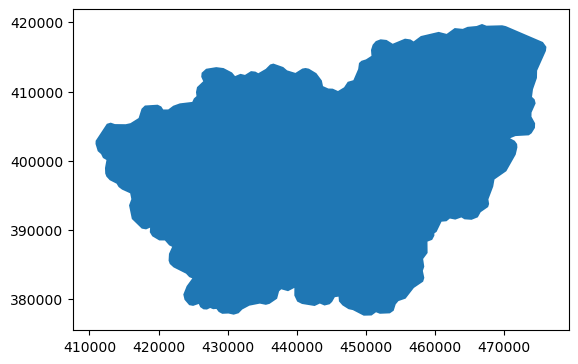

In [3]:
boundary = gpd.read_file('data/processed/boundary.geojson')
boundary.plot()

# Load the datasets

The modelling will use the following datasets:
- Digital Surface Model (DSM) & Digital Terrain Model (DTM) to derive a canopy height model (CHM) which is a key feature in predicting vegetation height
- Sentinel-2 (S2) imagery to classify pixels as vegetation or non-vegetation
- Vegetation height data from the Environment Agency (EA) to train the model. This data has gaps so can't be used directly.

In [4]:
dtm = rxr.open_rasterio('data/processed/dtm-10m.tif')
dsm = rxr.open_rasterio('data/processed/dsm-10m.tif')
veg_height = rxr.open_rasterio('data/processed/vegetation-height.tif')

In [5]:
# Sentinel-2
sentinel_2 = xr.open_mfdataset('data/raw/big-files/sentinel-2/*.tif', combine='by_coords', engine="rasterio")
sentinel_2

<xarray.Dataset>
Dimensions:      (band: 12, x: 10988, y: 4212)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float64 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

In [6]:
# From earth engine
band_names = list(sentinel_2.band_data.attrs['long_name'])
sentinel_2 = sentinel_2.band_data.to_dataset(dim='band').rename({i + 1: "s2_" + band_names[i] for i in range(12)})
sentinel_2

<xarray.Dataset>
Dimensions:      (y: 4212, x: 10988)
Coordinates:
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
Data variables:
    s2_B1        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B7        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8A       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B9        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        4884
    STATISTICS_MEAN:           1371.1649519329
    STATISTICS_MINIMUM:        1053.5
    STATISTICS_STDDEV:         241.71580333102
    STATISTICS_VALID_PERCENT:  100
    long_name:                 ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8...

# No Data Values

In [7]:
# Convert the nodata values to np.nan and write them for each dataset variable


def write_nodata(array):
    nodata_value = array.rio.nodata
    if nodata_value is not None:
        array = array.where(array != nodata_value, np.nan)
    # set dtype to float32
    array = array.astype(np.float32)
    array.rio.write_nodata(np.nan, inplace=True)
    return array

sentinel_2_arr = sentinel_2.to_array()
sentinel_2_arr = write_nodata(sentinel_2_arr)
sentinel_2 = sentinel_2_arr.to_dataset(dim='variable')

dtm = write_nodata(dtm)
dsm = write_nodata(dsm)
veg_height = write_nodata(veg_height)



# Clip the data to the boundary bbox

In [8]:
boundary_buffer = boundary.copy()
boundary_buffer["geometry"] = boundary.buffer(7000)
bbox = tuple(boundary_buffer.total_bounds)


sentinel_2 = sentinel_2.rio.clip_box(*bbox, crs=boundary_buffer.crs)
dtm = dtm.rio.clip_box(*bbox, crs=boundary_buffer.crs)
dsm = dsm.rio.clip_box(*bbox, crs=boundary_buffer.crs)
veg_height = veg_height.rio.clip_box(*bbox, crs=boundary_buffer.crs)

# Align the Rasters

To model the data the rasters all need to be aligned so that a pixel in one raster corresponds to the same location as a pixel in another raster.

In [9]:
veg_height = veg_height.rio.reproject_match(sentinel_2)
dsm = dsm.rio.reproject_match(sentinel_2)
dtm = dtm.rio.reproject_match(sentinel_2)

# Drop the band dimension 
veg_height = veg_height.squeeze()
dsm = dsm.squeeze()
dtm = dtm.squeeze()

The arrays need to be converted to datasets with variable names and then stacked with the sentinel image.

In [10]:
dsm = dsm.to_dataset(name='dsm')
dtm = dtm.to_dataset(name='dtm')
veg_height = veg_height.to_dataset(name='veg_height')

In [11]:
image_stack = xr.merge([sentinel_2, dsm, dtm, veg_height])

In [12]:
image_stack

<xarray.Dataset>
Dimensions:      (x: 10988, y: 4212)
Coordinates:
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
    band         int64 1
Data variables: (12/15)
    s2_B1        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    ...           ...
    s2_B9        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dsm          (y, x) float32 230.8 230.8 231.8 231.8 ... 28.94 29.2 29.2 29.7
    dtm          (y, x) float32 230.8 230.8 231.8 231.8 ... 29.2 29.2 29.69
    veg_height   (y, x) float32 nan nan nan nan nan ... 1.165 1.165 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        4884
    STATISTICS_MEAN:           1371.1649519329
    STATISTICS_MINIMUM:        1053.5
    STATISTICS_STDDEV:         241.71580333102
    STATISTICS_VALID_PERCENT:  100
    long_name:                 ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8...
    _FillValue:                nan

# Create the training dataset

Write the data out to a file. The data needds to be in two seperate rasters. One for the veg height (y - what I want to predict), the other for the lidar and sentinel-2 data (X - my prediction inputs).

In [25]:
image_stack = image_stack.rio.reproject(27700)

In [26]:
image_stack.attrs['long_name'] = tuple(image_stack.data_vars.keys())
image_stack.to_array().rio.to_raster('data/processed/s2-lidar/s2-lidar-stack.tif')

In [23]:
tuple(image_stack.data_vars.keys())

('s2_B1',
 's2_B2',
 's2_B3',
 's2_B4',
 's2_B5',
 's2_B6',
 's2_B7',
 's2_B8',
 's2_B8A',
 's2_B9',
 's2_B11',
 's2_B12',
 'dsm',
 'dtm',
 'veg_height')

In [13]:
# Write an X and a y dataset
X = image_stack.drop('veg_height')
y = image_stack['veg_height']

In [22]:
list(X.data_vars.keys())

['s2_B1',
 's2_B2',
 's2_B3',
 's2_B4',
 's2_B5',
 's2_B6',
 's2_B7',
 's2_B8',
 's2_B8A',
 's2_B9',
 's2_B11',
 's2_B12',
 'dsm',
 'dtm']

In [15]:
# Set the long_name attribute as a tuple of the dataset variable names
# Need to do this because the to_raster function was throwing an error
X.attrs['long_name'] = tuple(X.data_vars.keys())
# Convert to array to avoid issues with nan values. don't know why this is necessary
X.to_array().rio.to_raster('data/processed/s2-lidar/x/sentinel-lidar-image-stack.tif')


# Write the vegetation height raster
y.rio.to_raster('data/processed/s2-lidar/y/vegetation-height.tif')

# Mask

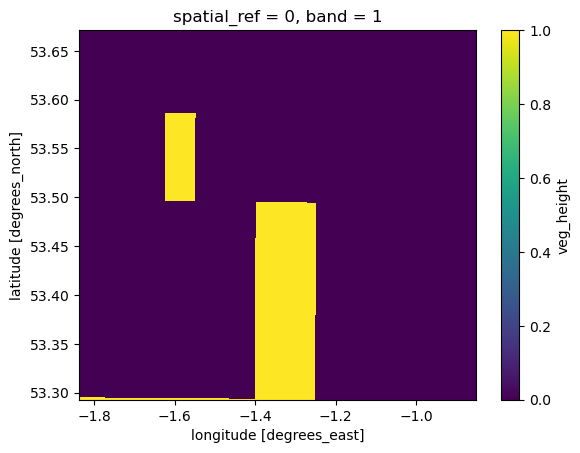

In [32]:
# Generate a mask to represent the areas where there is na or inf values
mask = np.isnan(y) | np.isinf(y)
mask.plot()